<a href="https://colab.research.google.com/github/PrajjwalNakarmi/Artificial-Intelligence/blob/main/AirQualityIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import requests
import seaborn as sns

In [33]:
url = "https://admin.opendatanepal.com/api/action/datastore_search"

resource_id = "ad8d1b4d-7667-455d-ab74-d5966e8ba4c3"

all_records = []
offset = 0
limit = 1000

while True:
    params = {
        "resource_id": resource_id,
        "sort": "_id asc",
        "limit": limit,
        "offset": offset
    }

    response = requests.get(url, params=params)
    data = response.json()

    records = data["result"]["records"]
    all_records.extend(records)

    if len(records) < limit:
        break

    offset += limit

df = pd.DataFrame(all_records)

print("Total records fetched:", len(df))
print(df.head())


Total records fetched: 60779
   _id locationId                               location       city country  \
0    1       3459  US Diplomatic Post: Embassy Kathmandu  Kathmandu      NP   
1    2       3459  US Diplomatic Post: Embassy Kathmandu  Kathmandu      NP   
2    3       3459  US Diplomatic Post: Embassy Kathmandu  Kathmandu      NP   
3    4       3459  US Diplomatic Post: Embassy Kathmandu  Kathmandu      NP   
4    5       3459  US Diplomatic Post: Embassy Kathmandu  Kathmandu      NP   

                         utc                      local parameter  value  \
0  2021-03-12T18:15:00+00:00  2021-03-13T00:00:00+05:45        o3  0.057   
1  2021-03-12T18:15:00+00:00  2021-03-13T00:00:00+05:45      pm25     50   
2  2021-03-12T17:15:00+00:00  2021-03-12T23:00:00+05:45      pm25     46   
3  2021-03-12T17:15:00+00:00  2021-03-12T23:00:00+05:45        o3  0.051   
4  2021-03-12T16:15:00+00:00  2021-03-12T22:00:00+05:45      pm25     45   

    unit   latitude  longitude  
0    p

In [34]:
print(df.columns)

Index(['_id', 'locationId', 'location', 'city', 'country', 'utc', 'local',
       'parameter', 'value', 'unit', 'latitude', 'longitude'],
      dtype='object')


In [35]:
# Keeping only relevant columns
df = df[['utc', 'parameter', 'value']]
# Convert value column to numeric (VERY IMPORTANT)
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df = df.dropna(subset=['value'])
print(df.dtypes)


utc           object
parameter     object
value        float64
dtype: object


In [36]:
df.to_csv("airquality.csv", index=False)
print("Dataset saved as airquality.csv")


Dataset saved as airquality.csv


In [37]:
df1 = df.pivot_table(
    index='utc',
    columns='parameter',
    values='value',
    aggfunc='mean'
).reset_index()

print(df1.head())
print(df1.columns)


parameter                        utc     o3   pm25
0          2017-03-02T23:15:00+00:00  0.004   54.5
1          2017-03-03T00:15:00+00:00  0.004   73.3
2          2017-03-03T01:15:00+00:00  0.003   76.1
3          2017-03-03T02:15:00+00:00  0.005   95.0
4          2017-03-03T03:15:00+00:00  0.009  208.5
Index(['utc', 'o3', 'pm25'], dtype='object', name='parameter')


In [38]:
df1 = df1.sort_values('utc')

# Interpolate missing values (environment-friendly)
df1 = df1.interpolate(method='linear')

# Fill any remaining missing values with median
df1 = df1.fillna(df1.median(numeric_only=True))


/tmp/ipython-input-668125487.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df1 = df1.interpolate(method='linear')


In [39]:
df_labeled = df1.copy()

def classify_air_quality(pm25):
    if pm25 <= 50:
        return 'Good'
    elif pm25 <= 100:
        return 'Moderate'
    else:
        return 'Poor'

df_labeled['air_quality'] = df_labeled['pm25'].apply(classify_air_quality)

print(df_labeled['air_quality'].value_counts())


air_quality
Good        22735
Moderate     7082
Poor         2422
Name: count, dtype: int64


In [40]:
#This Code was written first taking both pm2.5 and o3 features and models each gave 1.0 and 0.99 accuracy.
#The classification labels were generated using PM2.5 threshold rules, and PM2.5 was included as a feature.
#Decision Tree and Random Forest models can perfectly learn these rules, which resulted in 100% accuracy.
#This indicates rule learning rather than model generalization.

# Select features that actually exist
#features = [col for col in ['pm25', 'pm10', 'o3'] if col in df2.columns]

#df_model = df2[features].dropna()

#print("Features used:", features)
#print(df_model.head())



In [41]:
features = ['o3']  # NO pm25, NO pm10 that is why these were removed

df_model = df_labeled[features + ['air_quality']].dropna()

print(df_model.head())


parameter     o3 air_quality
0          0.004    Moderate
1          0.004    Moderate
2          0.003    Moderate
3          0.005    Moderate
4          0.009        Poor


In [42]:
X = df_model[features]
y = df_model['air_quality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [43]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)

dt_pred = dt.predict(X_test_scaled)

print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print(classification_report(y_test, dt_pred))

Decision Tree Accuracy: 0.711848635235732
              precision    recall  f1-score   support

        Good       0.73      0.97      0.83      4547
    Moderate       0.46      0.13      0.21      1417
        Poor       0.27      0.01      0.01       484

    accuracy                           0.71      6448
   macro avg       0.49      0.37      0.35      6448
weighted avg       0.64      0.71      0.63      6448



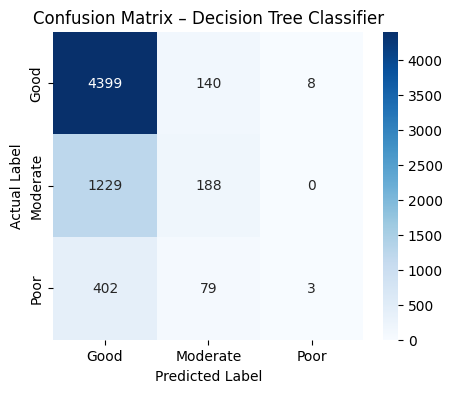

In [45]:
labels = ['Good', 'Moderate', 'Poor']
def plot_confusion_matrix(y_true, dt_pred, title):
    cm = confusion_matrix(y_true, dt_pred, labels=labels)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()
plot_confusion_matrix(y_test,dt_pred,"Confusion Matrix – Decision Tree Classifier")

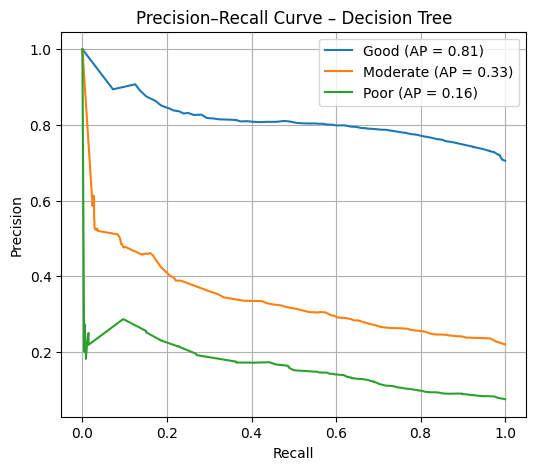

In [46]:
# Define class labels
classes = ['Good', 'Moderate', 'Poor']

# Binarize true labels
y_test_bin = label_binarize(y_test, classes=classes)

# Get predicted probabilities
y_score = dt.predict_proba(X_test_scaled)

plt.figure(figsize=(6,5))

for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(
        y_test_bin[:, i],
        y_score[:, i]
    )

    avg_precision = average_precision_score(
        y_test_bin[:, i],
        y_score[:, i]
    )

    plt.plot(
        recall,
        precision,
        label=f"{class_name} (AP = {avg_precision:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Decision Tree")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.7115384615384616
              precision    recall  f1-score   support

        Good       0.73      0.97      0.83      4547
    Moderate       0.46      0.13      0.21      1417
        Poor       0.23      0.01      0.01       484

    accuracy                           0.71      6448
   macro avg       0.47      0.37      0.35      6448
weighted avg       0.63      0.71      0.63      6448



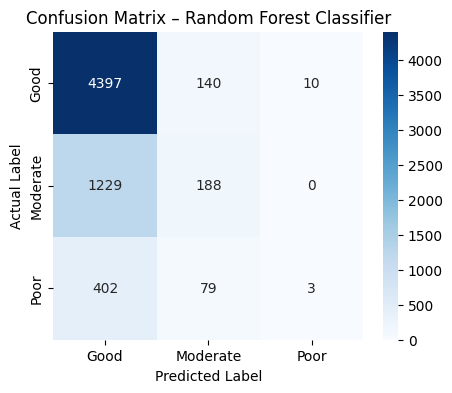

In [48]:
def plot_confusion_matrix(y_true, rf_pred, title):
    cm = confusion_matrix(y_true, rf_pred, labels=labels)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()
plot_confusion_matrix(y_test,rf_pred,"Confusion Matrix – Random Forest Classifier")

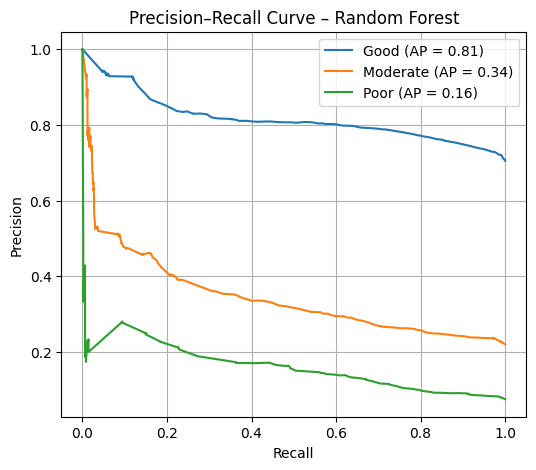

In [49]:
# Get predicted probabilities from Random Forest
y_score_rf = rf.predict_proba(X_test_scaled)

plt.figure(figsize=(6,5))

for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(
        y_test_bin[:, i],
        y_score_rf[:, i]
    )

    avg_precision = average_precision_score(
        y_test_bin[:, i],
        y_score_rf[:, i]
    )

    plt.plot(
        recall,
        precision,
        label=f"{class_name} (AP = {avg_precision:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Random Forest")
plt.legend()
plt.grid(True)
plt.show()


In [50]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

knn_pred = knn.predict(X_test_scaled)

print("KNN Accuracy:", accuracy_score(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

KNN Accuracy: 0.6786600496277916
              precision    recall  f1-score   support

        Good       0.73      0.91      0.81      4547
    Moderate       0.36      0.17      0.23      1417
        Poor       0.14      0.05      0.07       484

    accuracy                           0.68      6448
   macro avg       0.41      0.37      0.37      6448
weighted avg       0.60      0.68      0.63      6448



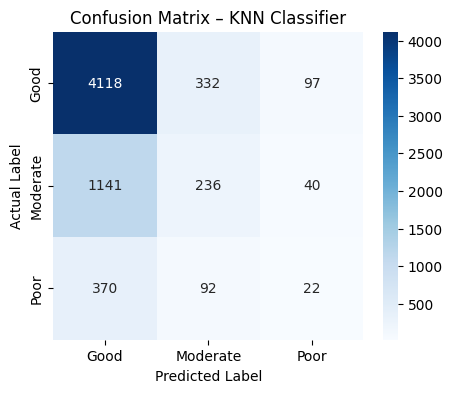

In [51]:
def plot_confusion_matrix(y_true, knn_pred, title):
    cm = confusion_matrix(y_true, knn_pred, labels=labels)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()
plot_confusion_matrix(y_test,knn_pred,"Confusion Matrix – KNN Classifier")

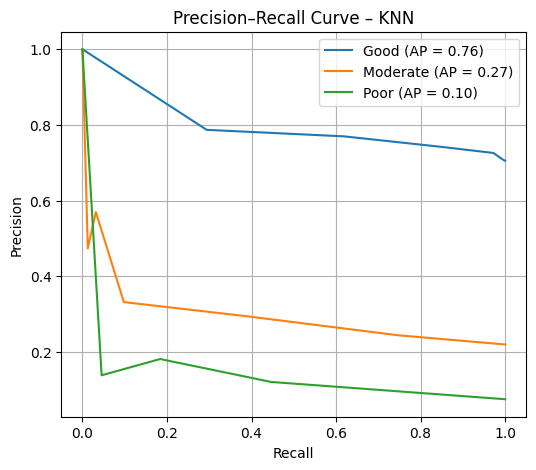

In [52]:
# Get predicted probabilities from KNN
y_score_knn = knn.predict_proba(X_test_scaled)

plt.figure(figsize=(6,5))

for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(
        y_test_bin[:, i],
        y_score_knn[:, i]
    )

    avg_precision = average_precision_score(
        y_test_bin[:, i],
        y_score_knn[:, i]
    )

    plt.plot(
        recall,
        precision,
        label=f"{class_name} (AP = {avg_precision:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – KNN")
plt.legend()
plt.grid(True)
plt.show()


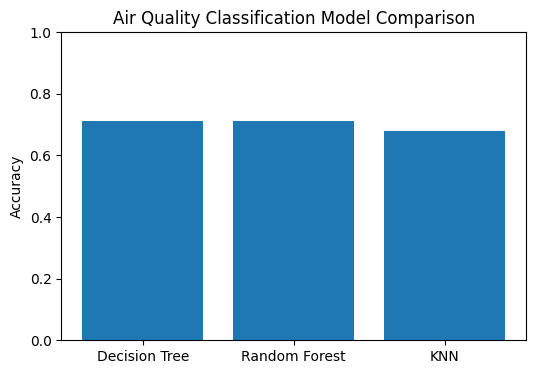

In [25]:
models = ['Decision Tree', 'Random Forest', 'KNN']
accuracies = [
    accuracy_score(y_test, dt_pred),
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, knn_pred)
]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.title("Air Quality Classification Model Comparison")
plt.ylim(0,1)
plt.show()

# Model in action

In [26]:
new_sample = np.array([[0.055]])

# Scale the input using trained scaler
new_sample_scaled = scaler.transform(new_sample)

# Predict air quality using trained Random Forest model
prediction = rf.predict(new_sample_scaled)

print("Predicted Air Quality:", prediction[0])


Predicted Air Quality: Good


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [30]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(
    hidden_layer_sizes=(10,),   # One hidden layer with 10 neurons
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
nn.fit(X_train_scaled, y_train)
nn_accuracy = nn.score(X_test_scaled, y_test)
print("Neural Network Accuracy:", nn_accuracy)
print("Neural Network Classification Report:\n")
print(classification_report(y_test, nn.predict(X_test_scaled)))



Neural Network Accuracy: 0.7051799007444168
Neural Network Classification Report:

              precision    recall  f1-score   support

        Good       0.71      1.00      0.83      4547
    Moderate       0.00      0.00      0.00      1417
        Poor       0.00      0.00      0.00       484

    accuracy                           0.71      6448
   macro avg       0.24      0.33      0.28      6448
weighted avg       0.50      0.71      0.58      6448



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
